<style>
.tit { 
    text-align: left; 
    font-family: Arial Black; 
    font-weight: bold; 
    font-size: 50px; 
    color: #06cc70; 
    text-shadow: -1px 0 #000, 0 1px #000, 3px 0 #000, 0 -1px #000;
}
</style>

<h1 class="tit">Data collection</h1>


The data collection process is a set of techniques and methods used to collect, extract, retrieve and store useful information for a specific purpose. This process is critical for a wide range of applications, including data analytics, artificial intelligence, and machine learning.

#### <span style="color:yellow">Load the dependencies used in the notebook</span>

Install packages that are requirements

In [ ]:
%pip install -r ../requirements.txt

**Import libraries**

In [1]:
# For system operations
import os, sys

# For ignoring warnings
import warnings

# For saving objects
import pickle

# For scraping
import requests

# Numpy (for arrays and matrices)
import numpy as np

# Pandas (for dataframes)
import pandas as pd

# Matplotlib (for plotting)
import matplotlib.pyplot as plt

# tqdm (for progress bars)
from tqdm import tqdm

# BeautifulSoup (for scraping)
from bs4 import BeautifulSoup

# SQLAlchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# Selenium (for scraping) 
from selenium import webdriver
from selenium.webdriver.common.by import By

# Own modules
# Add module olivia_finder to path
sys.path.append('../')
from olivia_finder.Util import *                                              # Utility functions                                     
from olivia_finder.ProxyRequest import RequestHandler                         # Proxy request handler
from olivia_finder.R.RPackage import RPackage                               # R package class                    
from olivia_finder.R.ROrmModel import *                                     # R ORM module
from olivia_finder.R.scraping.CranScraper import CranScraper                # CRAN scraper  
from olivia_finder.R.scraping.BiocScraper import BiocScraper                # Bioconductor scraper

# <ins>**1 - Using datasets**</ins>

## **1.1 - Data from libraries.io**

### 1.1.0 - Previous notes (about libraries.io):

<a href="https://libraries.io/">Libraries.io</a> is a platform that tracks and aggregates information about open source projects and software packages. 

Provides an overview of projects and packages, including information about their dependencies, development status, licenses, and supported platforms. This information can be useful for developers who are looking for specific projects and packages to include in their projects, or for those who simply want to explore the different options available. 

Furthermore, Libraries.io also allows users to monitor and receive notifications about changes and updates to specific projects and packages.

Taking into account the material provided by <a href="https://libraries.io/">libraries.io</a> as a source of information, a series of functions have been implemented to extract the data.
Libraries.io provides us with a compressed file that contains a series of datasets in csv format, each one of them contains the data referring to a standard classification, specifically and according to the documentation:

Libraries.io's data is organised into seven packages.

| Term | Definition |
| --- | --- |
| Projects | A Libraries.io project is the definition of a package available from one of the 32 Package Managers that it supports. |
| Versions | A Libraries.io version is a definition of an immutable published version of a Project from a package manager. Not all package managers have a concept of publishing versions, often relying directly on tags/branches from a source control. |
| Tags | A Libraries.io tag is equivalent to a tag in git or other source control systems. |
| Dependencies | Libraries.io dependencies belong to versions of a project, each version can have different sets of dependencies with different versions. Dependencies point at a specific version or range of versions of other projects, the resolution of that project version change over time as new versions are published and dependent on the specifics of the platform. Almost all package managers dependencies will be from the same package manager, although the extra `Dependency Platform` field exists otherwise. |
| Repositories | A Libraries.io repository represents a publically accessible source code repository from either github.com, gitlab.com or bitbucket.org. |
| Repository Dependencies | A Libraries.io repository dependency is where a dependency on a Project from a package manager has been specified in a manifest file, either as a manually added dependency committed by a user or listed as a generated dependency listed in a lockfile that has been automatically generated by a package manager and commited. |
| Projects with related Repository fields | This is an alternative projects export that denormalizes a projects related source code repository inline to reduce the need to join between two data sets. |

We can download the data from the following url:

- https://zenodo.org/record/3626071/files/libraries-1.6.0-2020-01-12.tar.gz 

<style>
.green {color: green;}
</style>
**Packages**

In relation to the previous note, for the analysis of the network of package dependencies in software repositories.

We are going to focus on the information provided by the Projects file <span class="green">projects-1.6.0-2020-01-12.csv</span>, where we can find information regarding the package and its metadata.

It has the following structure:

| Field Name | Data Type | Description |
| --- | --- | --- |
| ID  | integer | The unique primary key of the project in the Libraries.io database |
| Platform | string | The name of the Package manager the project is available on. |
| Name | string | The name of the project, unique by Platform (case sensitive). |
| Created Timestamp | datetime | The timestamp of when Libraries.io first discovered the project. |
| Updated Timestamp | datetime | The timestamp of when Libraries.io last saved a change to the project. |
| Description | string | Description provided by the package manager, falling back to description from repository if empty. |
| Keywords | string | Comma separated array of keywords if supported by package manager. |
| Homepage URL | string | URL of webpage or repository as provided by package managers that support it. |
| Licenses | string | Comma separated array of SPDX identifiers for licenses declared in package manager meta data or submitted manually by Libraries.io user via "project suggestion" feature. |
| Repository URL | string | URL of source code repository declared in package manager metadata or submitted manually by Libraries.io user via "project suggestion" feature. |
| Versions Count | integer | Number of published versions of the project found by Libraries.io. |
| SourceRank | integer | Libraries.io defined score based on quality, popularity and community metrics. |
| Latest Release Publish Timestamp | datetime | Time of the latest release detected by Libraries.io (ordered by semver, falling back to publish date for invalid semver). |
| Latest Release Number | string | Version number of the latest release detected by Libraries.io (ordered by semver, falling back to publish date for invalid semver). |
| Package Manager ID | integer | Unique ID of project from package manager API. |
| Dependent Projects Count | integer | Number of other projects that declare the project as a dependency in one or more of their versions. |
| Language | string | Primary programming language the project is written in, pulled from the repository if source is hosted on GitHub. |
| Status | string | The current status of the project, as determined by Libraries.io |

**Dependencies**

The dependencies file contains information about the dependencies of the packages, according to the documentation:

- Libraries.io dependencies belong to versions of a project, each version can have different sets of dependencies with different versions. Dependencies point at a specific version or range of versions of other projects, the resolution of that project version change over time as new versions are published and dependent on the specifics of the platform.

- Almost all package managers dependencies will be from the same package manager, although the extra `Dependency Platform` field exists otherwise

|Field|Type|Description|
|---|---|---|
|ID|integer|The unique primary key of the dependency in the Libraries.io database|
|Platform|string|The name of the package manager on which the dependency is available|
|Project Name|string|The name of the project the dependency belongs to|
|Project ID|integer|The project's unique primary key for this dependency in the Libraries.io database|
|Version Number|string|The version number to which the dependency belongs|
|Version ID|integer|The version's unique primary key for this dependency in the Libraries.io database|
|Dependency Name|string|The name of the project that specifies the dependency|
|Dependency Platform|string|The name of the package manager from which the project specifying the dependency is available|
|Dependency Kind|string|The kind of dependency, often declared for the use phase, eg runtime, test, develop, compile.|
|Optional Dependency|boolean|Is the dependency optional?|
|Dependency Requirements|string|The version or range of versions that the dependency specifies, the resolution of that specific version is specific to the package manager.|
|Dependency Project ID|integer|The unique project primary key for this dependency in the Libraries.io database|

### 1.1.1 - Data filtering

#### Extract package data from libraries.io projects csv

Since this Notebook is focused on CRAN as a proof of concept and due to the large file size, we have isolated the CRAN data in a new dataset.

We generate a new csv that will contain only the CRAN data

**Note:** 

The file ***projects-1.6.0-2020-01-12.csv*** is very large, for this reason it is not included in the repository, you can download the data from the link provided above

We leave the code commented so as not to carry out this process every time the notebook is executed


In [ ]:
# # Read the csv file and extract the data with column 'Platform' = 'CRAN' to a new dataframe
data_path = '/media/dnllns/Externo/libraries_data/libraries-1.6.0-2020-01-12/projects-1.6.0-2020-01-12.csv'
packages_df = pd.read_csv(data_path)
packages_df = packages_df[packages_df['Platform'] == 'CRAN']

# Save the new dataframe to a csv file
out_path = 'data' + os.sep + 'datasets' + os.sep + 'R' + os.sep + 'libraries_io' + os.sep + 'cran_librariesio_packages.csv'
packages_df.to_csv(out_path, index=False)

Finally we visualize the generated csv

In [9]:
# Read the csv file generated from the previous step
out_path = 'data' + os.sep + 'datasets' + os.sep + 'R' + os.sep + 'libraries_io' + os.sep + 'cran_librariesio_packages.csv'
packages_df = pd.read_csv(out_path)
packages_df.head(2)

,ID,Platform,Name,Created Timestamp,Updated Timestamp,Description,Keywords,Homepage URL,Licenses,Repository URL,...,SourceRank,Latest Release Publish Timestamp,Latest Release Number,Package Manager ID,Dependent Projects Count,Language,Status,Last synced Timestamp,Dependent Repositories Count,Repository ID
0,687281,CRAN,archivist,2015-03-02 00:48:14 UTC,2019-10-11 14:26:28 UTC,"Tools for Storing, Restoring and Searching for...",NaN,https://pbiecek.github.io/archivist/,GPL-2.0,https://github.com/pbiecek/archivist,...,14,2019-08-31 00:00:00 UTC,2.3.4,NaN,6,HTML,NaN,2019-10-11 14:26:25 UTC,12,339318.0
1,687282,CRAN,ggthemes,2015-03-02 00:48:15 UTC,2019-05-13 09:52:57 UTC,"Extra Themes, Scales and Geoms for 'ggplot2'",NaN,http://github.com/jrnold/ggthemes,GPL-2.0,https://github.com/jrnold/ggthemes,...,19,2019-05-13 00:00:00 UTC,4.2.0,NaN,64,R,NaN,2019-05-13 09:52:55 UTC,232,339319.0


We can see that in total we have 16695 packages in the CRAN csv

In [11]:
# Count the number of projects in the dataframe
print('Number of packages: {}'.format(len(packages_df)))

Number of packages: 16695


As an example, let's get the data of the A3 package

In [12]:
# Get the A3 package data from the df dataframe
packages_df[packages_df['Name'] == 'A3']

,ID,Platform,Name,Created Timestamp,Updated Timestamp,Description,Keywords,Homepage URL,Licenses,Repository URL,...,SourceRank,Latest Release Publish Timestamp,Latest Release Number,Package Manager ID,Dependent Projects Count,Language,Status,Last synced Timestamp,Dependent Repositories Count,Repository ID
5143,692488,CRAN,A3,2015-03-02 01:14:48 UTC,2019-10-11 17:58:17 UTC,"Accurate, Adaptable, and Accessible Error Metr...",NaN,NaN,"CNRI-Python-GPL-Compatible,CNRI-Python-GPL-Com...",NaN,...,5,2015-08-16 00:00:00 UTC,1.0.0,NaN,0,NaN,NaN,2019-10-11 17:58:17 UTC,0,NaN


#### Extract package-dependency data from libraries.io dependencies csv

As before, we are going to extract this information from the dependencies file

In [17]:
data_path = '/media/dnllns/Externo/libraries_data/libraries-1.6.0-2020-01-12/projects-1.6.0-2020-01-12.csv'
dependencies_df = pd.read_csv(data_path, nrows=10)
dependencies_df.head(2)

,ID,Platform,Name,Created Timestamp,Updated Timestamp,Description,Keywords,Homepage URL,Licenses,Repository URL,...,SourceRank,Latest Release Publish Timestamp,Latest Release Number,Package Manager ID,Dependent Projects Count,Language,Status,Last synced Timestamp,Dependent Repositories Count,Repository ID
0,1,Alcatraz,21st digital Templates,2015-01-11 23:56:18 UTC,2020-01-13 01:02:01 UTC,"A starting point for stripped down, structured...",NaN,https://github.com/21stdigital/Xcode-Templates,NaN,https://github.com/21stdigital/Xcode-Templates,...,5,2020-01-13 01:01:47 UTC,NaN,NaN,0,Objective-C,NaN,2020-01-13 01:01:53 UTC,0,3945.0
1,2,Alcatraz,ACCodeSnippetRepository,2015-01-11 23:56:18 UTC,2020-01-13 01:01:44 UTC,Synchronize code snippets with a git repository.,NaN,https://github.com/acoomans/ACCodeSnippetRepos...,MIT,https://github.com/acoomans/ACCodeSnippetRepos...,...,11,2014-03-13 18:40:38 UTC,0.0.4,NaN,0,Objective-C,NaN,2020-01-13 01:01:44 UTC,0,3943.0


This file is very large and the machine I have does not have enough RAM to open it, so the only solution is to cut it into smaller pieces.

In a linux system we can use the following command to split the file into files of 10000 lines each

In [5]:
#!cat dependencies-1.6.0-2020-01-12.csv | parallel --header : --pipe -N10000 'cat >dependencies-1.6.0-2020-01-12/split_dependencies-1.6.0-2020-01-12_{#}.csv'

We can see that the file has been divided into 19040 smaller files.

In [7]:
## Count the number of files in the directory
PATH_ = '/media/dnllns/Externo/libraries_data/libraries-1.6.0-2020-01-12/' 
!ls -l $PATH_"dependencies-1.6.0-2020-01-12" | wc -l

19040


We process the chunks individually and load the dataframe

In [10]:
warnings.filterwarnings("ignore", category=FutureWarning)

chunks_path = '/media/dnllns/Externo/libraries_data/libraries-1.6.0-2020-01-12/dependencies-1.6.0-2020-01-12/'
files = os.listdir(chunks_path)

# Process dependency files
# If the row has a 'CRAN' value in the 'Dependency Platform' column, it is saved in a new dataframe
dependencies_df = pd.DataFrame()
file_count = 0
pbar = tqdm(total=len(files))
for file in files:
    if file.endswith(".csv"):
        file_count += 1
        temp_dependencies_df = pd.read_csv(chunks_path + file)
        dependencies_df = pd.concat([dependencies_df, temp_dependencies_df[temp_dependencies_df['Dependency Platform'] == 'CRAN']])
    pbar.update(1)
pbar.close()

# Save the new dataframe to a csv file
out_path = 'data' + os.sep + 'datasets' + os.sep + 'R' + os.sep + 'libraries_io' + os.sep + 'cran_librariesio_dependencies.csv'
dependencies_df.to_csv(out_path, index=False)

100%|██████████| 19039/19039 [1:12:52<00:00,  4.35it/s]    


Once all the files have been processed we have a csv that contains the dependencies of the CRAN packages.


We will show the dependencies of the A3 package of type imports and depends for version 1.0.0

In [19]:
data_path = 'data' + os.sep + 'datasets' + os.sep + 'R' + os.sep + 'libraries_io' + os.sep + 'cran_librariesio_dependencies.csv'
dependencies_df = pd.read_csv(data_path)
dependencies_df.head(2)

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
0,66065047,CRAN,nmfem,2524222,1.0.0,11273453,R,CRAN,depends,False,*,NaN
1,66065056,CRAN,nmfem,2524222,1.0.0,11273453,plyr,CRAN,imports,False,*,691054.0


#### Visualize the data

In [20]:
dependency_packages = set(dependencies_df['Dependency Name'].values)
packages_with_dependencies = set(dependencies_df['Project Name'].values)
total_packages = set(packages_df['Name'].values)
packages_without_dependencies = total_packages - packages_with_dependencies
print('Total packages: ', len(total_packages))
print('Total packages with dependencies : ', len(dependency_packages | packages_with_dependencies))
print('Total packages that are dependencies of others: ', len(dependency_packages))
print('Total packages without dependencies: ', len(packages_without_dependencies))

Total packages:  16695
Total packages with dependencies :  16174
Total packages that are dependencies of others:  5501
Total packages without dependencies:  1173


We build a histogram to represent the analyzed information

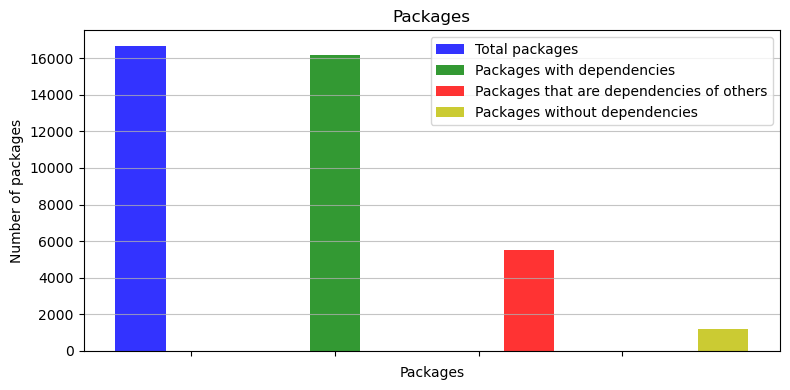

In [21]:
# Data to plot as a histogram
data1 = [len(total_packages), 0, 0, 0]
data2 = [0, len(dependency_packages | packages_with_dependencies), 0, 0]
data3 = [0, 0, len(dependency_packages), 0]
data4 = [0, 0, 0, len(packages_without_dependencies)]

fig, ax = plt.subplots(figsize=(8, 4))
index = np.arange(4)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, data1, bar_width, alpha=opacity, color='b', label='Total packages')
rects2 = plt.bar(index+bar_width, data2, bar_width, alpha=opacity, color='g', label='Packages with dependencies')
rects3 = plt.bar(index+2*bar_width, data3, bar_width, alpha=opacity, color='r', label='Packages that are dependencies of others')
rects4 = plt.bar(index+3*bar_width, data4, bar_width, alpha=opacity, color='y', label='Packages without dependencies')
plt.xlabel('Packages')
plt.ylabel('Number of packages')
plt.title('Packages')
plt.xticks(index + bar_width, ())

# Add a grid    
plt.grid(axis='y', alpha=0.75)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


---

# <ins>**2 - Web Scraping**</ins>

## **2.1 - Implementation Details**

**ProxyRequest module**

To carry out the task of obtaining data through web scraping, the module ***ProxyRequest*** with the class ***RequestHandler*** has been implemented to make the operation more transparent.


The RequestHandler module allows us to make requests using different *proxies and useragents* with the aim of avoiding the denial of service by the server to our requests, which will happen if or if due to their high number.

The implementation of the class is not defined in this notebook due to not extending the contents much.

You can see the implementation of the module and more information at:

- https://github.com/dab0012/olivia-finder/blob/master/olivia_finder/ProxyRequest.py



**RScraper module**

This module has been implemented with the objective of extracting the information of the packages housed on the **CRAN** & **Bioconductor** website.

This websites contains a list of packages currently availables, as well as the packages that have been filed (orphanage or by express desire for the maintainer)

The **CranScraper** & **BiocScraper** classes implemented allows us to extract the information stored in the HTML and process it with the aim of generating an object of the package class that we have previously implemented.

You can see the implementation of the module in the next URL:

- https://github.com/dab0012/olivia-finder/blob/master/olivia_finder/R/scraping/CranScraper.py
- https://github.com/dab0012/olivia-finder/blob/master/olivia_finder/R/scraping/BiocScraper.py

## **2.2 - Scraping process**

### **2.2.1 - Package processing** 

We do a test getting a package

In [3]:
cran_scraper = CranScraper(RequestHandler())       # Create object of class CranScraper
p = cran_scraper.build('MASS')                      # Get the MASS package data
p.dump()                                            # Print the package data                     

Name: MASS
Description:
Functions and datasets to support Venables and Ripley, "Modern Applied Statistics with S" (4th edition, 2002).
Version: 7.3-58.2
Publication date: 2023-01-23
Mantainer: Brian Ripley <ripley@stats.ox.ac.uk>
Authors:
Brian Ripley [aut, cre, cph], Bill Venables [ctb], Douglas M. Bates [ctb], Kurt Hornik [trl] (partial port ca 1998), Albrecht Gebhardt [trl] (partial port ca 1998), David Firth [ctb]
Dependencies:
  - R (≥ 3.3.0) type: depends
  - grDevices, type: depends
  - graphics, type: depends
  - stats, type: depends
  - utils, type: depends
  - methods, type: imports
Requires compilation: True
In CRAN: True
In Bioconductor: None
Licenses:
GPL-2 | GPL-3
Links:
https://cran.r-project.org/package=MASS



As can be seen thanks to this implementation, it is now quite simple to obtain an initialized package object with the website data of the repository to which it belongs.

The only thing that should know his name.

### **2.2.2 - Scraping CRAN website**

Once all the tools have been obtained, the only thing left is to obtain the information of each of the packages.

#### **2.2.2.1 - Get a list of package names**

**<span style="color:yellow">Get data from cran.r-project.org</span>**

We make a request to the CRAN web server and get the list of packages

In [2]:
# URL to get the list of packages from CRAN
CRAN_pkgs_url = "https://cran.r-project.org/web/packages/available_packages_by_name.html"

# Create object of class RequestHandler
rh = RequestHandler()

# Do the request
response = rh.do_request(CRAN_pkgs_url, retry=True)

# If the request was successful
if response.status_code == 200:
    print("Request successful")
else:
    print("Error in request")

Request successful


If the request was correct, we will begin to extract the information we need

**<span style="color:yellow">Get package names via scraping</span>**

We will use the BeautifullSoup4 library to do the scraping

In [3]:
# We parse the HTML content of the web page using BeautifulSoup
# We extract the table that contains the information of the CRAN packages
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("table")
rows = table.find_all("tr")
# Clean the first row of the table (it contains the headers)
rows.pop(0)

We import the Packages module, whose implementation is documented in the 'Data storage and Persistence' notebook

We also import the Util module, which contains code to garnish the stdout output (Nothing relevant)

In [ ]:
packages = []

# We iterate over each row of the table
for row in rows:

    # We extract the cells of the current row
    cells = row.find_all("td")

    package_name = ""
    # If there are cells in the row
    if cells:
        try: 
            # We extract the name of the package
            # The name is in the first cell of the row
            package_name = cells[0].find("a").text   

            # We add the package name to the list of packages
            packages.append(package_name)

            # Show success message
            message = "Package " + package_name + " added to the list"
            print_colored(message, GREEN)
            

        # If an error occurs, we show the error message
        except Exception as e:
            
            # message string
            message = "Error processing package: " + package_name
            message += "Exception: " + e.__class__.__name__ 
            message += "Error: " + str(e)

            # Print error message
            print_colored(message, RED)
            print("Continuing...")

In [8]:
# We show the number of packages that we have processed
print("Number of packages processed: ", len(packages))

Number of packages processed:  19248


**<span style="color:yellow">Store package names in a file</span>**

We can store the list of packages in a file so as not to repeat this step more times unless we want to update. 
<span style="color:red;">Be careful not to crush the file!</span>

In [ ]:
# file_name = "data" + os.sep + "persistence" + os.sep + "R" + os.sep + "scraping" + os.sep + "cran_pkg_name_list.pkl"

# # Drop file if it exists
# if os.path.exists(file_name):
#     os.remove(file_name)

# # We open the file in write mode
# with open(file_name, "wb") as f:
#     # We dump the packages list in the file
#     pickle.dump(packages, f)

**<span style="color:yellow">Inspect the data</span>**

We are going to show some basic statistics to get a little better idea of ​​the data we have.

In [9]:
# Compare the list of packages obtained by scraping with the list of packages obtained by the libraries.io dataset
# -------------------------------------------------------------------------------------------------------------

cran_scraped_names_file = "data" + os.sep + "persistence" + os.sep + "R" + os.sep + "scraping" + os.sep + "cran_pkg_name_list.pkl"

# We load the list of packages obtained by scraping
with open(cran_scraped_names_file, "rb") as f:
    packages_scraping = pickle.load(f)

# We load the list of packages obtained by the libraries.io dataset, from the csv file
cran_librariesio_file = "data" + os.sep + "datasets" + os.sep + "R" + os.sep + "libraries_io" + os.sep + "cran_librariesio_packages.csv"
packages_librariesio = pd.read_csv(cran_librariesio_file)

# We get the names of the packages obtained by scraping
packages_scraping_names = set(packages_scraping)

# We get the names of the packages obtained by the libraries.io dataset
packages_librariesio_names = set(packages_librariesio['Name'].values)

# We get the packages that are in the libraries.io dataset, but not in the scraping dataset
packages_librariesio_not_in_scraping = packages_librariesio_names - packages_scraping_names

# We get the packages that are in the scraping dataset, but not in the libraries.io dataset
packages_scraping_not_in_librariesio = packages_scraping_names - packages_librariesio_names

In [10]:
print("Number of packages in the libraries.io dataset: ", len(packages_librariesio_names))
print("Number of packages in the scraping dataset: ", len(packages_scraping_names))
print("Number of packages in the libraries.io dataset, but not in the scraping dataset: ", len(packages_librariesio_not_in_scraping))
print("Number of packages in the scraping dataset, but not in the libraries.io dataset: ", len(packages_scraping_not_in_librariesio))

# We show the number of packages that are in both datasets
print("Number of packages in both datasets: ", len(packages_scraping_names & packages_librariesio_names))

Number of packages in the libraries.io dataset:  16695
Number of packages in the scraping dataset:  19248
Number of packages in the libraries.io dataset, but not in the scraping dataset:  4091
Number of packages in the scraping dataset, but not in the libraries.io dataset:  6644
Number of packages in both datasets:  12604


We create a bar graph to visualize the size of the repositories

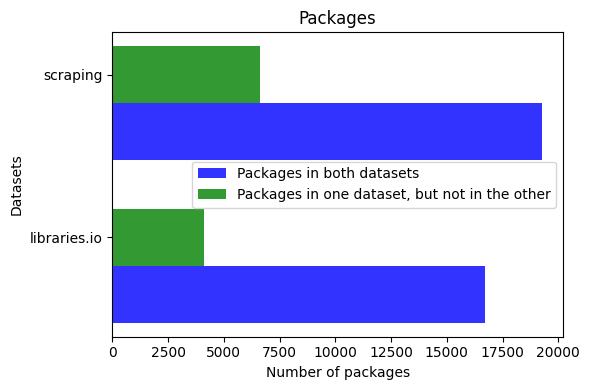

In [11]:
# Graphical representation of the previous results with a bar chart
# ------------------------------------------------------------------

# We create the data to represent in the bar chart
data1 = [len(packages_librariesio_names), len(packages_scraping_names)]
data2 = [len(packages_librariesio_not_in_scraping), len(packages_scraping_not_in_librariesio)]
labels = ["libraries.io", "scraping"]
plt.figure(figsize=(6, 4))
bar_width = 0.35
opacity = 0.8
index = np.arange(len(labels))

# We create the bars in horizontal position
rects1 = plt.barh(index, data1, bar_width, alpha=opacity, color='b', label='Packages in both datasets')
rects2 = plt.barh(index + bar_width, data2, bar_width, alpha=opacity, color='g', label='Packages in one dataset, but not in the other')

# We add the labels to the bars
plt.xlabel('Number of packages')
plt.ylabel('Datasets')
plt.title('Packages')
plt.yticks(index + bar_width, labels)
plt.legend()

plt.tight_layout()
plt.show()


#### **2.2.2.2 - Scrape package data**

The web scraping process is very expensive due to the multiple requests that are going to be made on the server, and the long time that this task requires.

**<span style="color:yellow">Load data from file</span>**

We get the package list from the pkl file

In [11]:
cran_scraped_names_file = "data" + os.sep + "persistence" + os.sep + "R" + os.sep + "scraping" + os.sep + "cran_pkg_name_list.pkl"

# We open the file in read mode
with open(cran_scraped_names_file, "rb") as f:
    # We load the list of packages
    CRAN_package_name_list = pickle.load(f)

**<span style="color:yellow">Do the scraping and save the objects file</span>**

Once we have the list with the packages we have to obtain, we execute the next code and the scraping process begins.

In [ ]:
scraper = CranScraper(RequestHandler())        # Create object of class CranScraper
CRAN_packages_objects_list = scraper.build_list(CRAN_package_name_list)

# Save the list of packages objects in a pickle file
cran_scraped_objects_file = "data" + os.sep + "persistence" + os.sep + "R" + os.sep + "scraping" + os.sep + "cran_pkg_obj_list.pkl"

# Drop file if it exists
if os.path.exists(cran_scraped_objects_file):
    os.remove(cran_scraped_objects_file)

# We open the file in write mode
with open(cran_scraped_objects_file, "wb") as f:
    # We dump the packages list in the file
    pickle.dump(CRAN_packages_objects_list, f)

**<span style="color:yellow">See a package</span>**

Once the process is finished we can obtain any **CRAN** package

In [ ]:
# open the file in read mode
cran_scraped_objects_file = "data" + os.sep + "persistence" + os.sep + "R" + os.sep + "scraping" + os.sep + "cran_pkg_obj_list.pkl"

with open(cran_scraped_objects_file, "rb") as f:
    # We load the list of packages
    CRAN_packages_objects_list = pickle.load(f)

# Dump the first package
p = CRAN_packages_objects_list[0]  
p.dump()

### **2.2.3 - Scraping Bioconductor website**

**<span style="color:yellow">Get data from bioconductor.org</span>**

Making scraping at bioconductor webpage is more difficult.

The problem is that the bioconductor web server loads the data in the HTML using JQuery, so these data can only be obtained  from the browser.

The above can be verified, if you do the scraping process and then check the document *data/bioconductor_raw.html* you can see that the data table is empty.

In [10]:
# Scraping the Bioconductor website
url = "https://www.bioconductor.org/packages/release/BiocViews.html#___Software"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Save the html file
with open("data" + os.sep + "bioconductor_raw.html", "w") as f:
    f.write(str(soup))

**As an alternative we have several options:**
- <span style="color: yellow">Easy way:</span> We can manually save the HTML with the rendered data using our browser.

    It is as simple as addressing the URL with the pack of packages and save the document on the disk.

- <span style="color:yellow">Automated way:</span> We can use some Python library like **Selenium** that provides us an headless browser that will be able to run Javascript code, now containing if data to extract. 

    - https://selenium-python.readthedocs.io/

    The following two cells show this process using selenium
    
    It is necessary to select a browser driver and load it in the code. In this case the driver *gecko* has been used for the browser *Firefox*

    - https://github.com/mozilla/geckodriver/releases
    
    - https://sites.google.com/a/chromium.org/chromedriver/downloads

    The driver container folder must be available at PATH

**Add the folder containing the driver to the Path**

In [ ]:
# Add the folder where the Firefox's selenium driver 
sys.path.append("./drivers/")

# Check the path
for path in sys.path:
    print(path)

**Save the data table on an HTML file using selenium**

In [13]:

driver = webdriver.Firefox()
driver.get("https://www.bioconductor.org/packages/release/BiocViews.html#___Software")
table = driver.find_element(By.ID, "biocViews_package_table")
table_content = table.get_attribute("innerHTML")

# Store the content of the table in an HTML file
with open("data" + os.sep + "bioconductor_selenium.html", "w") as f:
    f.write(table_content)

driver.close()

Now if everything went well we have the data correctly loaded

**<span style="color:yellow">Do the scraping and build a package name list backup file</span>**

Once we have the data, we can continue using ***BeautifulSoup*** to extract them

In [4]:
soup = BeautifulSoup(open("data" + os.sep + "bioconductor_selenium.html"), "html.parser")

# Process the HTML to obtain packages
bioc_packages = []
for row in soup.find_all("tr"):
    for cell in row.find_all("td"):
        if cell.find("a"):
            bioc_packages.append(cell.find("a").text)

print("Number of packages: ", len(bioc_packages))
bioc_packages[:5]

Number of packages:  2183


['BiocGenerics', 'S4Vectors', 'BiocVersion', 'GenomeInfoDb', 'IRanges']

**<span style="color:yellow">Save the package name list as a file</span>**

We save the data in a file so as not to repeat the process

In [5]:
# file_name = "bioconductor_package_name_list.pkl"
# # Delete the file if it already exists
# if os.path.exists("data" + os.sep + file_name):
#     os.remove("data" + os.sep + file_name)

# # Save the list of packages in a pkl file
# with open("data" + os.sep + file_name, "wb") as f:
#     pickle.dump(bioc_packages, f)

**<span style="color:yellow">Load the data from the names backup file</span>**

Load the data from the file, so we avoid performing the process of obtaining again

In [2]:
file_name = "bioconductor_package_name_list.pkl"
# Load the list of packages from the pkl file
with open("data" + os.sep + file_name, "rb") as f:
    bioc_packages = pickle.load(f)

print("Number of packages: ", len(bioc_packages))

Number of packages:  2183


**We can easily obtain the data in the following way**

In [4]:
scraper = BiocScraper(RequestHandler())
p = scraper.build("a4")
p.dump()

Name: a4
Description:
Umbrella package is available for the entire Automated Affymetrix Array Analysis suite of package.
Version: 1.46.0
Publication date: None
Mantainer: Laure Cougnaud <laure.cougnaud@openanalytics.eu>
Authors:
Author: Willem Talloen [aut], Tobias Verbeke [aut], Laure Cougnaud [cre]
Dependencies:
  - a4Base, type: depends
  - a4Preproc, type: depends
  - a4Classif, type: depends
  - a4Core, type: depends
  - a4Reporting, type: depends
Requires compilation: None
In CRAN: None
In Bioconductor: True
Licenses:
GPL-3
Links:
https://www.bioconductor.org/packages/release/bioc/html/a4.html



**<span style="color:yellow">Do the scraping of the package data and build objects backup file</span>**


We proceed to obtain all the bioconductor packages

In [5]:
# Scraping the Bioconductor website to get the list of packages
bioc_package_list = scraper.build_list(bioc_packages)

file_name = "bioconductor_package_object_list.pkl"
# Delete the file if it already exists
if os.path.exists("data" + os.sep + file_name):
    os.remove("data" + os.sep + file_name)

# Save the list of packages in a pkl file
with open("data" + os.sep + file_name, "wb") as f:
    pickle.dump(bioc_package_list, f)

Scraped package BiocGenerics: 1/2183
Scraped package S4Vectors: 2/2183
Scraped package BiocVersion: 3/2183
Scraped package GenomeInfoDb: 4/2183
Scraped package IRanges: 5/2183
Scraped package Biobase: 6/2183
Scraped package zlibbioc: 7/2183
Scraped package XVector: 8/2183
Scraped package Biostrings: 9/2183
Scraped package BiocParallel: 10/2183
Scraped package GenomicRanges: 11/2183
Scraped package DelayedArray: 12/2183
Scraped package SummarizedExperiment: 13/2183
Scraped package MatrixGenerics: 14/2183
Scraped package limma: 15/2183
Scraped package AnnotationDbi: 16/2183
Scraped package KEGGREST: 17/2183
Scraped package annotate: 18/2183
Scraped package BiocFileCache: 19/2183
Scraped package Rhtslib: 20/2183
Scraped package Rsamtools: 21/2183
Scraped package genefilter: 22/2183
Scraped package edgeR: 23/2183
Scraped package GenomicAlignments: 24/2183
Scraped package biomaRt: 25/2183
Scraped package rtracklayer: 26/2183
Scraped package Rhdf5lib: 27/2183
Scraped package graph: 28/2183
S

**<span style="color:yellow">Visualize some data</span>**

In [ ]:
# Get the first package
p = bioc_package_list[0]
p.dump()

## **2.3 - Data export**

In this section the issue of export of the data obtained is going to be discussed.

As a format, a CSV file has been chosen with the same structure used by ***Libraries.io*** and in turn ***Olivia***

**We remember the structure of the CSV:**

The CSV to generate will have a structure similar to the CSV of dependencies to try to make the maximum with Olivia.

In [2]:
dependencies_df = pd.read_csv('data/dependencies-1.6.0-2020-01-12-cran.csv')

# We show the first 5 rows of the dataframe
dependencies_df.head()

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
0,66065047,CRAN,nmfem,2524222,1.0.0,11273453,R,CRAN,depends,False,*,NaN
1,66065056,CRAN,nmfem,2524222,1.0.0,11273453,plyr,CRAN,imports,False,*,691054.0
2,66065066,CRAN,nmfem,2524222,1.0.0,11273453,dplyr,CRAN,imports,False,*,688151.0
3,66065076,CRAN,nmfem,2524222,1.0.0,11273453,d3heatmap,CRAN,imports,False,*,957160.0
4,66065086,CRAN,nmfem,2524222,1.0.0,11273453,mixtools,CRAN,imports,False,*,690560.0


**To generate these CSV we use the data obtained through scraping**

### **2.3.1 - Building CRAN csv**

**<span style="color:yellow">Load the package objects</span>**

First we load the list of objects generated above

In [18]:
# Read the file with the list of bioconductor packages
with open("data" + os.sep + "CRAN_package_object_list.pkl", "rb") as f:
    CRAN_package_list = pickle.load(f)

print("Number of packages: ", len(CRAN_package_list))

Number of packages:  19248


**<span style="color:yellow">Build the csv</span>**


We prepare the CSV structure

In [20]:
# ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
columns = [
    "ID",
    "Platform",
    "Project Name",
    "Project ID",
    "Version Number", 
    "Version ID", 
    "Dependency Name", 
    "Dependency Platform", 
    "Dependency Kind", 
    "Optional Dependency", 
    "Dependency Requirements", 
    "Dependency Project ID"
]

# We create a dataframe with the data from the Bioconductor packages
CRAN_df = pd.DataFrame(columns=columns)

We generate the CSV from the data

In [21]:
# For each Cran package, we store the dependencies in the dataframe
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for p in tqdm(CRAN_package_list):
    for d in p.dependencies:

        # Build the row
        d = {
            "ID": None,
            "Platform": "CRAN",
            "Project Name": p.name,
            "Project ID": None,
            "Version Number": p.version,
            "Version ID": None,
            "Dependency Name": d.name,
            "Dependency Platform": "CRAN",
            "Dependency Kind": d.type,
            "Optional Dependency": None,
            "Dependency Requirements": None,
            "Dependency Project ID": None,
        }
        
        # Add the row to the dataframe
        CRAN_df = CRAN_df.append(d, ignore_index=True)

100%|██████████| 19248/19248 [15:29<00:00, 20.71it/s]


In [22]:
# Save the dataframe in a csv file
CRAN_df.to_csv("data" + os.sep + "CRAN_scraped_dependencies.csv", index=False)


### **2.3.2 - Building Bioconductor csv**

**<span style="color:yellow">Load package object data</span>**


The process is the same as we have done in the previous section for CRAN

In [8]:
# Read the file with the list of bioconductor packages
with open("data" + os.sep + "bioconductor_package_object_list.pkl", "rb") as f:
    bioc_package_list = pickle.load(f)

**<span style="color:yellow">Build csv file</span>**


In [4]:
# ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
columns = [
    "ID",
    "Platform",
    "Project Name",
    "Project ID",
    "Version Number", 
    "Version ID", 
    "Dependency Name", 
    "Dependency Platform", 
    "Dependency Kind", 
    "Optional Dependency", 
    "Dependency Requirements", 
    "Dependency Project ID"
]

# We create a dataframe with the data from the Bioconductor packages
bioc_df = pd.DataFrame(columns=columns)

In [5]:
# For each Bioconductor package, we store the dependencies in the dataframe
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for p in tqdm(bioc_package_list):
    for d in p.dependencies:

        # Build the row
        d = {
            "ID": None,
            "Platform": "Bioconductor",
            "Project Name": p.name,
            "Project ID": None,
            "Version Number": p.version,
            "Version ID": None,
            "Dependency Name": d.name,
            "Dependency Platform": "Bioconductor",
            "Dependency Kind": d.type,
            "Optional Dependency": None,
            "Dependency Requirements": None,
            "Dependency Project ID": None,
        }
        
        # Add the row to the dataframe
        bioc_df = bioc_df.append(d, ignore_index=True)


100%|██████████| 2183/2183 [01:30<00:00, 24.16it/s]


In [7]:
# Save the dataframe in a csv file
bioc_df.to_csv("data" + os.sep + "bioconductor_scraped_dependencies.csv", index=False)

**<span style="color:yellow">Visualize some data</span>**

In [5]:
# Load the dataframe from the csv file
bioc_df = pd.read_csv("data" + os.sep + "bioconductor_scraped_dependencies.csv")
bioc_df.tail(10)

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
27769,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,tools,Bioconductor,imports,NaN,NaN,NaN
27770,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,data.table,Bioconductor,imports,NaN,NaN,NaN
27771,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,Biostrings,Bioconductor,imports,NaN,NaN,NaN
27772,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,IRanges,Bioconductor,imports,NaN,NaN,NaN
27773,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,VariantAnnotation,Bioconductor,imports,NaN,NaN,NaN
27774,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,seqminer,Bioconductor,imports,NaN,NaN,NaN
27775,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,ggplot2,Bioconductor,imports,NaN,NaN,NaN
27776,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,biomaRt,Bioconductor,imports,NaN,NaN,NaN
27777,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,readxl,Bioconductor,imports,NaN,NaN,NaN
27778,NaN,Bioconductor,XCIR,NaN,1.12.0,NaN,S4Vectors,Bioconductor,imports,NaN,NaN,NaN


**<span style="color:yellow">Compare object integrity vs registration in the CSV</span>**

As can be seen below, the information is consistent and identical in both structures

In [6]:
# Make a lil check
bioc_df[bioc_df["Project Name"] == "GenomeInfoDb"]

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
16,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,R,Bioconductor,depends,NaN,NaN,NaN
17,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,methods,Bioconductor,depends,NaN,NaN,NaN
18,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,BiocGenerics,Bioconductor,depends,NaN,NaN,NaN
19,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,S4Vectors,Bioconductor,depends,NaN,NaN,NaN
20,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,IRanges,Bioconductor,depends,NaN,NaN,NaN
21,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,stats,Bioconductor,imports,NaN,NaN,NaN
22,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,stats4,Bioconductor,imports,NaN,NaN,NaN
23,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,utils,Bioconductor,imports,NaN,NaN,NaN
24,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,RCurl,Bioconductor,imports,NaN,NaN,NaN
25,NaN,Bioconductor,GenomeInfoDb,NaN,1.34.9,NaN,GenomeInfoDbData,Bioconductor,imports,NaN,NaN,NaN


In [9]:
bioc_package_list[3].dump()

Name: GenomeInfoDb
Description:
Contains data and functions that define and allow translation between different chromosome sequence naming conventions (e.g., "chr1" versus "1"), including a function that attempts to place sequence names in their natural, rather than lexicographic, order.
Version: 1.34.9
Publication date: None
Mantainer: HervÃ© PagÃ¨s <hpages.on.github@gmail.com>
Authors:
Author: Sonali Arora [aut], Martin Morgan [aut], Marc Carlson [aut], HervÃ© PagÃ¨s [aut, cre], Prisca Chidimma Maduka [ctb], Atuhurira Kirabo Kakopo [ctb], Emmanuel Chigozie Elendu [ctb]
Dependencies:
  - R (>= 4.0.0) type: depends
  - methods, type: depends
  - BiocGenerics, type: depends
  - S4Vectors, type: depends
  - IRanges, type: depends
  - stats, type: imports
  - stats4, type: imports
  - utils, type: imports
  - RCurl, type: imports
  - GenomeInfoDbData, type: imports
Requires compilation: None
In CRAN: None
In Bioconductor: True
Licenses:
Artistic-2.0
Links:
https://www.bioconductor.org/pac

# <ins>**3 - Libraries.io web API**</ins>

Libraries.io offers us an API through which we can obtain the data referred to the beginning of this notebook.

Unfortunately, if we have no data of the packages in the repository, we cannot obtain any data, since the API requires specifying the name of the package for which we want to obtain information.

We can get more information about the API at:

- https://libraries.io/api

**Basic example of use of the API:**

We get a list of 30 repositories available in *Libraries.io*

In [4]:
api_key = "dcc8a237b15dac0e6334df54bd9573fb"

# make a request to the API
response = requests.get("https://libraries.io/api/platforms?api_key=" + api_key)
print(response.status_code)
print(response.text)

200
[{"name":"NPM","project_count":2881884,"homepage":"https://www.npmjs.com","color":"#f1e05a","default_language":"JavaScript"},{"name":"Pypi","project_count":530299,"homepage":"https://pypi.org/","color":"#3572A5","default_language":"Python"},{"name":"Maven","project_count":525139,"homepage":"http://maven.org","color":"#b07219","default_language":"Java"},{"name":"Go","project_count":439688,"homepage":"https://pkg.go.dev","color":"#375eab","default_language":null},{"name":"NuGet","project_count":419199,"homepage":"https://www.nuget.org","color":"#178600","default_language":"C#"},{"name":"Packagist","project_count":373571,"homepage":"https://packagist.org","color":"#4F5D95","default_language":"PHP"},{"name":"Rubygems","project_count":182775,"homepage":"https://rubygems.org","color":"#701516","default_language":"Ruby"},{"name":"Cargo","project_count":106988,"homepage":"https://crates.io","color":"#dea584","default_language":"Rust"},{"name":"CocoaPods","project_count":92180,"homepage":"h

There is a Python wrapper for the API.

- https://pypi.org/project/pybraries/
- https://pybraries.readthedocs.io/en/latest/stubs/pybraries.search.Search.html

In [ ]:
# Set up the environment variables using python
import os
os.environ['LIBRARIES_API_KEY'] = 'dcc8a237b15dac0e6334df54bd9573fb'

# Import the libraries api wrapper
from pybraries import Search   

In [5]:
search = Search()
repo_list = search.platforms() 
print("Repositories: ")
for repo in repo_list:
    print(repo['name'] + "; ", end='')

print("\n\nCRAN's A3 package data at libraries.io:")
A3_api = search.project("CRAN", "A3")
for key, value in A3_api.items():
    print(key + ": " + str(value))

Repositories: 
NPM; Pypi; Maven; Go; NuGet; Packagist; Rubygems; Cargo; CocoaPods; Bower; CPAN; Pub; Clojars; CRAN; Conda; Hackage; Hex; Meteor; Homebrew; Puppet; Carthage; SwiftPM; Julia; Elm; Dub; Racket; Nimble; Haxelib; PureScript; Alcatraz; Inqlude; 

CRAN's A3 package data at libraries.io:
dependent_repos_count: 0
dependents_count: 0
deprecation_reason: None
description: Accurate, Adaptable, and Accessible Error Metrics for Predictive
Models
forks: 0
homepage: None
keywords: []
language: None
latest_download_url: https://cran.r-project.org/src/contrib/A3_1.0.0.tar.gz
latest_release_number: 1.0.0
latest_release_published_at: 2015-08-16T00:00:00.000Z
latest_stable_release_number: 1.0.0
latest_stable_release_published_at: 2015-08-16T00:00:00.000Z
license_normalized: False
licenses: GPL-2 | GPL-3 [expanded from: GPL (≥ 2)]
name: A3
normalized_licenses: ['CNRI-Python-GPL-Compatible', 'CNRI-Python-GPL-Compatible']
package_manager_url: https://cran.r-project.org/package=A3
platform: CRA